In [183]:
from pylabeledrf.computeLRF import *
import dendropy
from dendropy.calculate import treecompare
import logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import random

In [147]:
taxa = dendropy.TaxonNamespace()
p53 = dendropy.Tree.get_from_path('NOX4.Ensembl99.nhx','newick', taxon_namespace=taxa)

In [263]:
def buildX(T):
    X = []
    n = len(T.leaf_nodes())
    tax2id = {}
    n2bip = {}

    def buildX_r(T):
        if T.is_leaf():
            # left right id2taxon nodeT1 nodeT2 sizeIsland1 sizeIsland2 labels1 labels2
            X.append([0,0,T.taxon,0,0,0,0,set(),set()])
            i = len(X)-1
            tax2id[T.taxon] = i
            return(i,i)
        else:
            min_l=n
            max_r=0
            for c in T.child_node_iter():
                l,r = buildX_r(c)
                min_l=min(l,min_l)
                max_r=max(r,max_r)
            X[min_l][0]=X[max_r][0]=min_l
            X[min_l][1]=X[max_r][1]=max_r
            X[min_l][3]=X[max_r][3]=T
            n2bip[T]=[min_l,max_r]
            return(min_l,max_r)
    buildX_r(T.seed_node)
    return(X,tax2id,n2bip)

In [283]:
def findgood(T,X,tax2id):
    n2bip = {}
    n = len(T.leaf_nodes())
    def findgood_r(t):
        if t.is_leaf():
            i = tax2id[t.taxon]
            return(i,i,1)
        else:
            min_l=n
            max_r=0
            tot_w=0
            for c in t.child_node_iter():
                l,r,w = findgood_r(c)
                min_l=min(l,min_l)
                max_r=max(r,max_r)
                tot_w+=w
            if max_r-min_l+1 == tot_w:
                if (X[min_l][0]==min_l and X[min_l][1]==max_r):
                    X[min_l][4]=t
                    n2bip[t]=[min_l,max_r]
                elif (X[max_r][0]==min_l and X[max_r][1]==max_r):
                    X[max_r][4]=t
                    n2bip[t]=[min_l,max_r]
            return(min_l,max_r,tot_w)
    findgood_r(T.seed_node)
    return(n2bip)
def getIslands2(t,X,n2bip,isT1):

    #                         ____
    #                        /
    #                 **** x6
    #                *       \___
    #         **** x3                ......
    #        *       \___    ______x7
    #   ----x1              /        ...
    #        *       **** x4        ____
    #         **** x2       ``--    /
    #                *********** x5
    #                              \_____
    #


    n = len(X)
    off = 5 if isT1 else 6

    def mytraversal(t,is_rooted,parentIslandId=0):

        if t.is_leaf():
            return()

        try: 
            [l,r] = n2bip[t]
        except KeyError:
            l=r=0 #dummy value 
        row=-1

        if (X[l][0]==l and X[l][1]==r and X[l][4]!=0):
            row=l
        elif (X[r][0]==l and X[r][1]==r and X[r][4]!=0):
            row=r

        # clade is in common 
        if row > -1:
            # end of previous island, so new island. 
            islandId = row
            X[row][off+2].add(t.label)
            for c in t.child_node_iter():
                mytraversal(c,is_rooted,islandId)
        else:
            # continue previous island
            islandId = parentIslandId
            # we process the node unless it's the fake root of an unrooted tree:
            if not is_rooted and len(t.adjacent_nodes()) == 2:
                if t.label != None:
                    warnings.warn('The root of an unrooted tree should not have a label')
            else:
                X[islandId][off+2].add(t.label)
                X[islandId][off] += 1

            for c in t.child_node_iter():
                mytraversal(c,is_rooted,islandId)

    mytraversal(t.seed_node, t.is_rooted)
    return()


In [436]:
t1 = parseEnsemblLabels(p53)
t3 = t1.clone(depth=1)
t2 = mutateLabeledTree(t1.clone(depth=1), 20, model='LRF')
t4 = t2.clone(depth=1)
randn = t2.find_node_for_taxon(random.choice(taxa))
t2.reroot_at_edge(randn.edge)

###
node_n1 = t1.find_node_for_taxon(taxa[-1])
t1.reroot_at_edge(node_n1.edge)
t1.prune_taxa([taxa[-1]])
node_n2 = t2.find_node_for_taxon(taxa[-1])
t2.reroot_at_edge(node_n2.edge)
t2.prune_taxa([taxa[-1]])
X, tax2id, n12bip = buildX(t1)
n22bip = findgood(t2,X,tax2id)

INFO:root:#flips 2 #col 17, #exp 1


In [437]:
#X
getIslands2(t1,X,n12bip,True)
getIslands2(t2,X,n22bip,False)
# compute distance
rf = subs = 0
for i in X:
    if i[4] != 0:
        rf += i[5]+i[6]
        if len(i[7].intersection(i[8])) == 0:
            subs +=1

print(rf,subs,rf+subs)

18 2 20


In [438]:
computeLRF(t3,t4)

INFO:root:Collapses needed between islands 4 and 4: 1+0
INFO:root:Substitution needed between 5 and 5
INFO:root:Collapses needed between islands 27 and 27: 1+0
INFO:root:Collapses needed between islands 47 and 47: 1+0
INFO:root:Substitution needed between 68 and 68
INFO:root:Collapses needed between islands 150 and 150: 1+0
INFO:root:Collapses needed between islands 54 and 54: 2+0
INFO:root:Collapses needed between islands 72 and 72: 1+1
INFO:root:Collapses needed between islands 37 and 37: 1+0
INFO:root:Collapses needed between islands 28 and 28: 1+0
INFO:root:Collapses needed between islands 144 and 144: 1+0
INFO:root:Collapses needed between islands 145 and 145: 1+0
INFO:root:Collapses needed between islands 61 and 61: 1+0
INFO:root:Collapses needed between islands 147 and 147: 1+0
INFO:root:Collapses needed between islands 49 and 49: 1+0
INFO:root:Collapses needed between islands 105 and 105: 1+0
INFO:root:Collapses needed between islands 99 and 99: 1+0
INFO:root:Collapses needed b

20

In [347]:
X

[[0,
  180,
  <Taxon 0x126f56310 'ENSSMRP00000012397'>,
  <Node object at 0x1283f7850: 'speciation' (None)>,
  <Node object at 0x12886c0d0: 'speciation' (None)>,
  0,
  0,
  {'speciation'},
  {'speciation'}],
 [0,
  1,
  <Taxon 0x126f56490 'ENSPMRP00000003465'>,
  <Node object at 0x128ab4950: 'speciation' (None)>,
  <Node object at 0x12886c910: 'speciation' (None)>,
  0,
  0,
  {'speciation'},
  {'speciation'}],
 [2,
  5,
  <Taxon 0x126f569d0 'ENSPTXP00000003920'>,
  <Node object at 0x128ab4d90: 'speciation' (None)>,
  <Node object at 0x12886c990: 'speciation' (None)>,
  0,
  0,
  {'speciation'},
  {'speciation'}],
 [2,
  3,
  <Taxon 0x126f56b50 'ENSNSUP00000000018'>,
  <Node object at 0x1275db090: 'speciation' (None)>,
  <Node object at 0x12886ced0: 'speciation' (None)>,
  0,
  0,
  {'speciation'},
  {'speciation'}],
 [2,
  4,
  <Taxon 0x126f56f50 'ENSACAP00000014675'>,
  <Node object at 0x1275db4d0: 'speciation' (None)>,
  <Node object at 0x12886ce10: 'speciation' (None)>,
  0,
  0,


In [354]:
t1.is_rooted()

TypeError: 'bool' object is not callable

In [192]:
tax2id

{<Taxon 0x126f56310 'ENSSMRP00000012397'>: 0,
 <Taxon 0x126f56490 'ENSPMRP00000003465'>: 1,
 <Taxon 0x126f569d0 'ENSPTXP00000003920'>: 2,
 <Taxon 0x126f56b50 'ENSNSUP00000000018'>: 3,
 <Taxon 0x126f56f50 'ENSACAP00000014675'>: 4,
 <Taxon 0x126f79350 'ENSVKKP00000018817'>: 5,
 <Taxon 0x1268d44d0 'ENSPVIP00000032889'>: 6,
 <Taxon 0x126db2d50 'ENSSPUP00000007481'>: 7,
 <Taxon 0x126adb490 'ENSACCP00020012081'>: 8,
 <Taxon 0x126aed950 'ENSANIP00000010210'>: 9,
 <Taxon 0x126f798d0 'ENSACUP00000000120'>: 10,
 <Taxon 0x126f79e10 'ENSACOP00000002942'>: 11,
 <Taxon 0x126f79f90 'ENSMUNP00000003223'>: 12,
 <Taxon 0x126f57410 'ENSSHBP00005006977'>: 13,
 <Taxon 0x126f57850 'ENSLCOP00000022547'>: 14,
 <Taxon 0x126f579d0 'ENSMVIP00005016846'>: 15,
 <Taxon 0x126f8da50 'ENSLSDP00000000850'>: 16,
 <Taxon 0x126f8d810 'ENSTGUP00000013282'>: 17,
 <Taxon 0x126f8d1d0 'ENSEGOP00005002776'>: 18,
 <Taxon 0x126f8d310 'ENSSCAP00000003933'>: 19,
 <Taxon 0x126f8dc10 'ENSJHYP00000023421'>: 20,
 <Taxon 0x126f8b090 'EN

In [57]:
def getGoodedges(T,X):
    g = []

b1,bTn1 = identify_labelled_bipartitions(t1)
print(b1)

[<dendropy.datamodel.treemodel.Bipartition object at 0x125ded090>, <dendropy.datamodel.treemodel.Bipartition object at 0x125ded890>, <dendropy.datamodel.treemodel.Bipartition object at 0x125ded550>, <dendropy.datamodel.treemodel.Bipartition object at 0x125ded3d0>, <dendropy.datamodel.treemodel.Bipartition object at 0x125ded7d0>, <dendropy.datamodel.treemodel.Bipartition object at 0x1257fd0d0>, <dendropy.datamodel.treemodel.Bipartition object at 0x125de9b50>, <dendropy.datamodel.treemodel.Bipartition object at 0x125de9b90>, <dendropy.datamodel.treemodel.Bipartition object at 0x125de9fd0>, <dendropy.datamodel.treemodel.Bipartition object at 0x125de9610>, <dendropy.datamodel.treemodel.Bipartition object at 0x125de9450>, <dendropy.datamodel.treemodel.Bipartition object at 0x125de98d0>, <dendropy.datamodel.treemodel.Bipartition object at 0x125de9310>, <dendropy.datamodel.treemodel.Bipartition object at 0x1257fdd90>, <dendropy.datamodel.treemodel.Bipartition object at 0x1257fde50>, <dendropy

In [5]:
nsamples = 10
ndist = 20
taxa = dendropy.TaxonNamespace()
p53 = dendropy.Tree.get_from_path('NOX4.Ensembl99.nhx','newick', taxon_namespace=taxa)
t1 = parseEnsemblLabels(p53)
t = t1.clone(depth=1)
#t = cloneAndReroot(t1)

random.seed(12)
abort = False
res_rf = []
res_s = []

logging.root.level = 40
for i in range(0,ndist):
    res_rf.append([])
    res_s.append([])
    for j in range(0,nsamples):
        t2 = mutateLabeledTree(t.clone(depth=1), i, model='LRF')
        res_s[i].append(computeLRF(t,t2))
        res_rf[i].append(treecompare.symmetric_difference(t,t2))

res = []
logging.root.level = 40
for i in range(0,ndist):
    res.append([])
    for j in range(0,nsamples):
        t2 = mutateLabeledTree(t.clone(depth=1), i, model='ELRF')        
        res[i].append(computeELRF(t,t2))

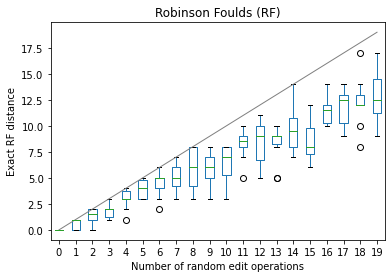

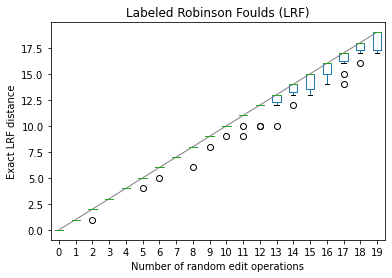

In [6]:
x = np.array(res_rf)
y = x.transpose()
df = pd.DataFrame(y)
#print('Standard Robinson Foulds:')

p1 = df.plot.box()
p1.set_title('Robinson Foulds (RF)')
p1.set_xlabel('Number of random edit operations')
p1.set_ylabel('Exact RF distance')
#z = np.linspace(*p1.get_xlim())
p1.plot(list(range(1,ndist+1)), list(range(0,ndist)), color = 'grey', linewidth = 1)
o1 = p1.get_figure()
o1.savefig('RF.pdf')

x = np.array(res_s)
y = x.transpose()
df = pd.DataFrame(y)
#print('Labelled Robinson Foulds:')
#df.plot.box()

p3 = df.plot.box()
p3.set_title('Labeled Robinson Foulds (LRF)')
p3.set_xlabel('Number of random edit operations')
p3.set_ylabel('Exact LRF distance')
#z = np.linspace(*p2.get_xlim())
p3.plot(list(range(1,ndist+1)), list(range(0,ndist)), color = 'grey', linewidth = 1)
o3 = p3.get_figure()
o3.savefig('LRF.pdf')

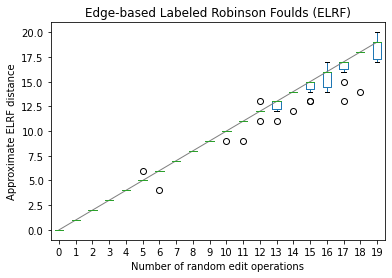

In [7]:
x = np.array(res)
y = x.transpose()
df = pd.DataFrame(y)
#print('Labelled Robinson Foulds:')
#df.plot.box()

p2 = df.plot.box()
p2.set_title('Edge-based Labeled Robinson Foulds (ELRF)')
p2.set_xlabel('Number of random edit operations')
p2.set_ylabel('Approximate ELRF distance')
#z = np.linspace(*p2.get_xlim())
p2.plot(list(range(1,ndist+1)), list(range(0,ndist)), color = 'grey', linewidth = 1)
o2 = p2.get_figure()
o2.savefig('ELRF.pdf')
